In [4]:
# !pip install pytube

In [42]:
from datasets.youtube_data import download_n_preprocess_youtube_video
from datasets.youtube_data import YoutubeVideoDataset

# Download new videos
url = 'https://www.youtube.com/watch?v=oMzc_OJqaF8'
vid_name = 'kyoto_drive_360p'
save_dir = 'D:/Implementation/VD/data/drive'
# download_n_preprocess_youtube_video(url, vid_name, save_dir)

# Just load the dataset
ydata = YoutubeVideoDataset(save_dir, frames_per_sample=4)

,,,

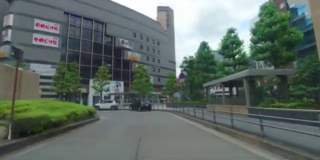
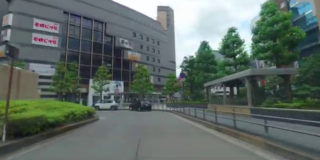
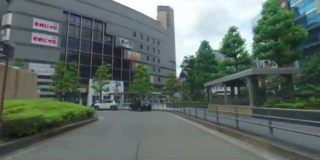
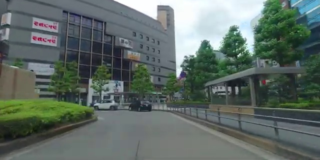

In [43]:
import mediapy as media
media.show_images(ydata[439][0].permute(0,2,3,1), height=500)

In [3]:
# Load Trained Checkpoint here 
print('Loading Trained Checkpoint')
import sys
import glob, os
import mediapy as media
import torch
from torch.utils.data import DataLoader

from load_model_from_ckpt import load_model, get_sampler, init_samples
from datasets import get_dataset, data_transform, inverse_data_transform
from runners.ncsn_runner import conditioning_fn

# from os.path import expanduser
# home = expanduser("~")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
EXP_PATH = 'D:/Implementation/VD/mcvd-pytorch/youtube_drive/'
ckpt_path = glob.glob(os.path.join(EXP_PATH, 'logs/checkpoint*.pt'))[0]
scorenet, config = load_model(ckpt_path, device)
sampler = get_sampler(config)

Loading Trained Checkpoint


In [4]:
# We can for instance load out dataset and the model and see if they successfully propagate towards each other
DATA_PATH = 'D:/Implementation/VD/data/drive'
# DATA_PATH = os.path.join(home, "scratch\Datasets\MNIST")
# config.data.dataset='YOUTUBEVIDEO'
# config.data.channels=3
# config.data.dataset='StochasticMovingMNIST'
dataset, test_dataset = get_dataset(DATA_PATH, config, video_frames_pred=config.data.num_frames)

In [35]:
test_loader = DataLoader(test_dataset, batch_size=config.training.batch_size, shuffle=False,
                         num_workers=config.data.num_workers, drop_last=True)
test_iter = iter(test_loader)
test_x, test_y = next(test_iter)
# print(test_x.shape)

test_x = data_transform(config, test_x) # shape is fine here
real, cond, cond_mask = conditioning_fn(config, test_x, num_frames_pred=config.data.num_frames,
                                        prob_mask_cond=getattr(config.data, 'prob_mask_cond', 0.0),
                                        prob_mask_future=getattr(config.data, 'prob_mask_future', 0.0))
init = init_samples(len(real), config)

In [36]:
pred = sampler(init, scorenet, cond=cond, cond_mask=cond_mask, subsample=100, verbose=True)

DDPM: 1/100, grad_norm: 553.8770751953125, image_norm: 501.16229248046875, grad_mean_norm: 38453.46484375
DDPM: 10/100, grad_norm: 554.0704345703125, image_norm: 505.4168395996094, grad_mean_norm: 38457.75
DDPM: 20/100, grad_norm: 554.465576171875, image_norm: 510.50946044921875, grad_mean_norm: 38401.890625
DDPM: 30/100, grad_norm: 556.6395874023438, image_norm: 514.7947998046875, grad_mean_norm: 38621.7734375
DDPM: 40/100, grad_norm: 561.4462280273438, image_norm: 516.5545654296875, grad_mean_norm: 38537.6640625
DDPM: 50/100, grad_norm: 574.5011596679688, image_norm: 510.33941650390625, grad_mean_norm: 38296.9921875
DDPM: 60/100, grad_norm: 610.7945556640625, image_norm: 489.1971435546875, grad_mean_norm: 38206.43359375
DDPM: 70/100, grad_norm: 696.9180908203125, image_norm: 444.89593505859375, grad_mean_norm: 37981.7421875
DDPM: 80/100, grad_norm: 908.335205078125, image_norm: 376.2501220703125, grad_mean_norm: 37882.30859375
DDPM: 90/100, grad_norm: 1559.3770751953125, image_norm: 

,,,

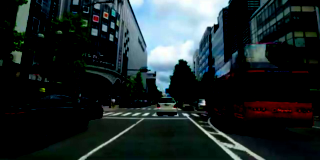
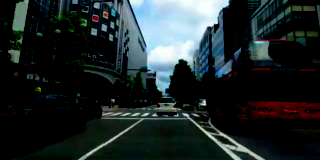
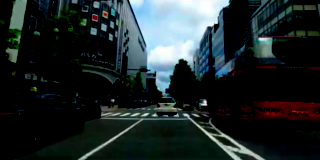
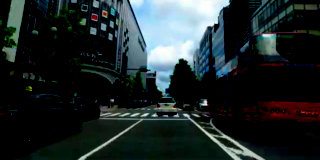

In [40]:
i = 7
cond_vis, real_vis = cond[i].view(config.data.num_frames_cond, config.data.channels, config.data.image_height, config.data.image_width), real[i].view(config.data.num_frames, config.data.channels, config.data.image_height, config.data.image_width)
pred_vis = pred[i].view(config.data.num_frames, config.data.channels, config.data.image_height, config.data.image_width)
# media.show_images(torch.cat([cond_vis, real_vis]).permute(0,2,3,1))
media.show_images(torch.cat([cond_vis, real_vis]).permute(0,2,3,1))

# media.show_images(torch.cat([cond_vis, pred_vis]).permute(0,2,3,1))

In [7]:
# Tha main function sotre the args, config in .yml files, we can reverse the process and obtain args, config 
# To replace the parse_args_and_config() functional, which do not work under jupyter lab, only under terminal command line
# Import the yaml module

import yaml
import os
import torch

log_path = './youtube_drive/logs'
# Open the YAML file that contains the config data
with open(os.path.join(log_path, 'config.yml'), "r") as f:
    # Load the YAML data as a Python dictionary
    config_dict = yaml.load(f, Loader=yaml.FullLoader)
# Open the YAML file that contains the args data
with open(os.path.join(log_path, 'args.yml'), "r") as f:
    # Load the YAML data as a Python dictionary
    args_dict = yaml.load(f, Loader=yaml.FullLoader)


from main import dict2namespace

args = dict2namespace(args_dict)
config = dict2namespace(config_dict)
config_uncond = dict2namespace(config_dict)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
config.device = device
config_uncond.device = device
# Try propagate inside a NCSNRunner: Successful connection ! 
from runners import *
runner = NCSNRunner(args, config, config_uncond)

# Debug on the runner, enable training with youtube video dataset here ! 
runner.train() # The Issue is NCSN model assumes squared image with H=W, but we need to extend it to variable Height and Width here ! 

DataParallel(
  (module): UNetMore_DDPM(
    (unet): NCSNpp(
      (act): SiLU()
      (all_modules): ModuleList(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
        (2): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3-5): 3 x ResnetBlockBigGANppGN(
          (actnorm0): get_act_norm(
            (act): SiLU()
            (act_emb): SiLU()
            (Dense_0): Linear(in_features=128, out_features=64, bias=True)
            (Norm_0): GroupNorm(8, 32, eps=1e-05, affine=False)
          )
          (Conv_0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (actnorm1): get_act_norm(
            (act): SiLU()
            (act_emb): SiLU()
            (Dense_0): Linear(in_features=128, out_features=64, bias=True)
            (Norm_0): GroupNorm(8, 32, eps=1e-05, affine=False)
          )
          (Dropout_0): Dropout(p=0.0, inplace=False)
         

KeyboardInterrupt: 

In [6]:
config.training.batch_size

8

In [7]:
from runners.ncsn_runner import get_model, get_optimizer, anneal_dsm_score_estimation, get_dataset
from torch.utils.data import DataLoader

# Issue is inside the train section of the NCSNRunner object -- we breakdown the NCSNRunner object and see where the issue is
scorenet = get_model(config) # model
optimizer = get_optimizer(config, scorenet.parameters()) # optimizer
# dataset & dataloader
dataset, test_dataset = get_dataset(args.data_path, config, video_frames_pred=config.data.num_frames, start_at=args.start_at)
dataloader = DataLoader(dataset, batch_size=config.training.batch_size, shuffle=True, num_workers=config.data.num_workers)

# values
conditional = config.data.num_frames_cond > 0
# Issue is in the confitioning functional
for batch, (X, y) in enumerate(dataloader):
    optimizer.zero_grad()
    # lr = warmup_lr(optimizer, step, getattr(self.config.optim, 'warmup', 0), self.config.optim.lr)
    scorenet.train()
    # Data
    X = X.to(config.device)
    X = data_transform(config, X) # The issue is with the data_transform functional -- it needs to resize on the image here !! 
    print('Pre-conditioning fn X shape: ', X.shape)
    X, cond, cond_mask = conditioning_fn(config, X, num_frames_pred=config.data.num_frames,
                                         prob_mask_cond=getattr(config.data, 'prob_mask_cond', 0.0),
                                         prob_mask_future=getattr(config.data, 'prob_mask_future', 0.0),
                                         conditional=conditional)
    print('Pass Conditioning Functional Noisy Future Frames shape: ', X.shape, ' Conditional Past Frames Shape: ', cond.shape)
    hook = None
    # Second Issue inside the loss computation function here
    print('Start Computing Loss functional --')
    loss = anneal_dsm_score_estimation(scorenet, X, labels=None, cond=cond, cond_mask=cond_mask,
                                                   loss_type=getattr(config.training, 'loss_type', 'a'),
                                                   gamma=getattr(config.model, 'gamma', False),
                                                   L1=getattr(config.training, 'L1', False), hook=hook,
                                                   all_frames=getattr(config.model, 'output_all_frames', False))
    print('Loss Computation Complete')
    break

Pre-conditioning fn X shape:  torch.Size([8, 4, 3, 160, 320])
Pass Conditioning Functional Noisy Future Frames shape:  torch.Size([8, 6, 160, 320])  Conditional Past Frames Shape:  torch.Size([8, 6, 160, 320])
Start Computing Loss functional --
Loss Computation Complete


In [7]:
from functools import partial

x = X
net = scorenet.module if hasattr(scorenet, 'module') else scorenet
version = getattr(net, 'version', 'SMLD').upper() # getattr works on the Namespace object, with the default value specified in the last argument
net_type = getattr(net, 'type') if isinstance(getattr(net, 'type'), str) else 'v1'

labels=None
cond=cond
cond_mask=cond_mask
loss_type=getattr(config.training, 'loss_type', 'a')
gamma=getattr(config.model, 'gamma', False)
L1=getattr(config.training, 'L1', False)
hook=hook
all_frames=getattr(config.model, 'output_all_frames', False)

version, all_frames, labels, gamma

alphas = net.alphas
if labels is None:
    labels = torch.randint(0, len(alphas), (x.shape[0],), device=x.device)
used_alphas = alphas[labels].reshape(x.shape[0], *([1] * len(x.shape[1:])))

z = torch.randn_like(x)

perturbed_x = used_alphas.sqrt() * x + (1 - used_alphas).sqrt() * z
scorenetpp = partial(scorenet, cond=cond)

# Loss
if L1:
    def pow_(x):
        return x.abs()
else:
    def pow_(x):
        return 1 / 2. * x.square()
# Issue is with the propagation of the scorenet object
loss = pow_((z - scorenetpp(perturbed_x, labels, cond_mask=cond_mask)).reshape(len(x), -1)).sum(dim=-1)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 44 but got size 45 for tensor number 1 in the list.

In [10]:
perturbed_x.shape, labels.shape, x.shape

(torch.Size([8, 6, 180, 320]), torch.Size([8]), torch.Size([8, 6, 180, 320]))

In [27]:
import models.better.layers as layers
unet = scorenetpp.func.unet
time_cond = labels
x = perturbed_x
modules = unet.all_modules
m_idx = 0

if cond is not None:
    x = torch.cat([x, cond], dim=1) # B, (num_frames+num_frames_cond)*C, H, W
# Time Conditional tensor Embedding
timesteps = time_cond
used_sigmas = unet.sigmas[time_cond.long()]
temb = layers.get_timestep_embedding(timesteps, unet.nf)
# 
temb = modules[m_idx](temb)
m_idx += 1
temb = modules[m_idx](unet.act(temb))
m_idx += 1

x = x.contiguous()

modules[m_idx]
print('Idx: ', m_idx, ' Height Resolution for hidden input: ', x.shape[2])
hs = [modules[m_idx](x)]
print('Idx: ', m_idx, ' Height Resolution for hidden output: ', hs[0].shape[2])
m_idx += 1
for i_level in range(unet.num_resolutions):
    # Residual Blocks for this resolution
    for i_block in range(unet.num_res_blocks):
        print('Residual Block')
        print('Idx: ', m_idx, ' Height Resolution for hidden input: ', hs[-1].shape[2])
        h = modules[m_idx](hs[-1], temb)
        print('Idx: ', m_idx, ' Height Resolution for hidden output: ', h.shape[2])
        m_idx += 1
        if h.shape[-1] in unet.attn_resolutions:
            print('Attn Block')
            print('Idx: ', m_idx, ' Height Resolution for hidden input: ', h.shape[2])
            h = modules[m_idx](h)
            print('Idx: ', m_idx, ' Height Resolution for hidden output: ', h.shape[2])
            m_idx += 1
        hs.append(h)
        
    if i_level != unet.num_resolutions - 1:
        print('Resblock')
        if unet.resblock_type == 'ddpm':
            h = modules[m_idx](hs[-1])
            m_idx += 1
        else:
            print('Idx: ', m_idx, ' Height Resolution for hidden input: ', h.shape[2])
            h = modules[m_idx](hs[-1], temb)
            print('Idx: ', m_idx, ' Height Resolution for hidden output: ', h.shape[2])
            m_idx += 1
        hs.append(h)

# Middle Block

# ResBlock
h = hs[-1]
print('Idx: ', m_idx, ' Height Resolution for hidden input: ', h.shape[2])
h = modules[m_idx](h, temb)
print('Idx: ', m_idx, ' Height Resolution for hidden output: ', h.shape[2])
m_idx += 1
# AttnBlock
print('Idx: ', m_idx, ' Height Resolution for hidden input: ', h.shape[2])
h = modules[m_idx](h)
print('Idx: ', m_idx, ' Height Resolution for hidden output: ', h.shape[2])
m_idx += 1

# ResBlock
print('Idx: ', m_idx, ' Height Resolution for hidden input: ', h.shape[2])
h = modules[m_idx](h, temb) # check on height resolution of h here
print('Idx: ', m_idx, ' Height Resolution for hidden output: ', h.shape[2])
m_idx += 1


# Upsampling block
for i_level in reversed(range(unet.num_resolutions)):
  for i_block in range(unet.num_res_blocks + 1): 
    prev = hs.pop()
    h_comb = torch.cat([h, prev], dim=1) # resolution height of h here is weird
    h = modules[m_idx](h_comb, temb)
    m_idx += 1

  if h.shape[-1] in unet.attn_resolutions:
    h = modules[m_idx](h)
    m_idx += 1

  if i_level != 0:
    if unet.resblock_type == 'ddpm':
      h = modules[m_idx](h)
      m_idx += 1
    else:
      h = modules[m_idx](h, temb)
      m_idx += 1

Idx:  2  Height Resolution for hidden input:  180
Idx:  2  Height Resolution for hidden output:  180
Residual Block
Idx:  3  Height Resolution for hidden input:  180
Idx:  3  Height Resolution for hidden output:  180
Residual Block
Idx:  4  Height Resolution for hidden input:  180
Idx:  4  Height Resolution for hidden output:  180
Residual Block
Idx:  5  Height Resolution for hidden input:  180
Idx:  5  Height Resolution for hidden output:  180
Resblock
Idx:  6  Height Resolution for hidden input:  180
Idx:  6  Height Resolution for hidden output:  90
Residual Block
Idx:  7  Height Resolution for hidden input:  90
Idx:  7  Height Resolution for hidden output:  90
Residual Block
Idx:  8  Height Resolution for hidden input:  90
Idx:  8  Height Resolution for hidden output:  90
Residual Block
Idx:  9  Height Resolution for hidden input:  90
Idx:  9  Height Resolution for hidden output:  90
Resblock
Idx:  10  Height Resolution for hidden input:  90
Idx:  10  Height Resolution for hidden ou

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 44 but got size 45 for tensor number 1 in the list.

In [ ]:
# python main.py --config configs/youtube_drive.yml --data_path D:/Implementation/VD/data/drive --exp youtube_drive --ni

python experiment.py --config configs/youtube_drive.yml --data_path D:/Implementation/VD/data/drive --exp youtube_drive --ni